In [ ]:
'''
ODE_PINN: Learns a global function u(x)~sin(x)
TOY_MODEL: Time step solver for given t to find t+^t -----  f(x_t, ^t)~x_t+1
    Future state predicted given previous state(s)
    f(state1, dt) = state2
Dead Reckoning: x_t+1=x_t+^t*v
'''

Epoch 0, Loss: 2.718602e+02
Epoch 200, Loss: 5.816564e+01
Epoch 400, Loss: 1.873575e+01
Epoch 600, Loss: 6.489048e+00
Epoch 800, Loss: 2.591227e+00
Epoch 1000, Loss: 1.167245e+00
Epoch 1200, Loss: 5.791619e-01
Epoch 1400, Loss: 3.121349e-01
Epoch 1600, Loss: 1.797557e-01
Epoch 1800, Loss: 1.088729e-01


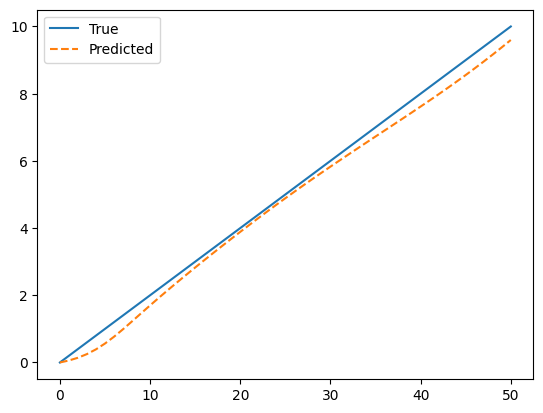

In [1]:
v = 2.0        # constant velocity
DT = 0.1       # nominal timestep

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def generate_trajectory(x0=0.0, v=2.0, dt=0.1, T=100):
    xs = [x0]
    for _ in range(T):
        xs.append(xs[-1] + v * dt)
    return torch.tensor(xs)

def build_training_pairs(xs, dt):
    X = []
    Y = []

    for t in range(len(xs) - 1):
        X.append([xs[t], dt])
        Y.append(xs[t + 1])

    return torch.tensor(X), torch.tensor(Y).view(-1, 1)

class TransitionNet(nn.Module):
    def __init__(self, width=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, 1)
        )

    def forward(self, x):
        return self.net(x)

def physics_residual(x_t, dt, x_pred, v):
    return x_pred - (x_t + v * dt)

def loss_fn(model, X, Y, v, lambda_phys=1.0):
    x_t = X[:, 0:1]
    dt  = X[:, 1:2]

    x_pred = model(X)

    data_loss = torch.mean((x_pred - Y)**2)
    phys_loss = torch.mean(physics_residual(x_t, dt, x_pred, v)**2)

    return data_loss + lambda_phys * phys_loss

def train(model, X, Y, v, epochs=2000, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        opt.zero_grad()
        loss = loss_fn(model, X, Y, v)
        loss.backward()
        opt.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6e}")

def rollout(model, x0, dt, steps):
    xs = [x0]
    x = torch.tensor([[x0, dt]])

    for _ in range(steps):
        x_next = model(x)
        xs.append(x_next.item())
        x = torch.tensor([[x_next.item(), dt]])

    return xs

# Generate data
xs = generate_trajectory()
X, Y = build_training_pairs(xs, DT)

# Train
model = TransitionNet()
train(model, X, Y, v)

# Roll forward
pred = rollout(model, x0=0.0, dt=DT, steps=50)

# Plot
true = xs[:51].numpy()
plt.plot(true, label="True")
plt.plot(pred, "--", label="Predicted")
plt.legend()
plt.show()